```
<Integrantes del Grupo>
<Sofia Oliverio
Ramiro Jimenez
Pablo Carrazana>
```

# Práctico 3 - Introducción al Aprendizaje Automático

## Modelos de Precios de Mercado
Queremos crear un modelo que prediga si el precio de una acción va a subir o bajar de acuerdo a información del pasado. Para ello implementaremos algunos modelos derivados de la teoria económica respecto de como valuar una activo con flujo de fondos inciertos, lo que estaría indicando que esas acciones tuvieron un rendimiento inferior al dado por  su índice de mercado(NASDAQ).


### Capital Asset Pricing Model (CAPM)

El modelo de CAPM propuesto por William Sharpe a partir del desarrollo de Markowitz sobre carteras eficientes, busca predecir el retorno de un activo en función del comportamiento global del mercado, y de la relación del activo puntual con el mercado. 

Según este modelo, que se puede expresar de la siguiente manera: 

$$
E(r_i) = r_f + \beta  [ E(r_m) - r_f ] 
$$

El retorno esperado del activo i, es igual al retorno libre de riesgo (o tasa libre de riesgo), más el exceso de retorno esperado de mercado (es decir lo que se espera que rinda el mercado por sobre la tasa libre de riesgo) escalado por un coeficiente beta. Este coeficiente beta es el conciente entre la covarianza del activo con el mercado sobre la varianza del mercado, y se interpreta como un multiplicador de riesgo de mercado.

Pueden ver una explicación completa en: https://economipedia.com/definiciones/modelo-valoracion-activos-financieros-capm.html

Adicionalmente, se puede agregar un término independiente como ordenada al origen alfa, que represanta una ganancia extraordinaria no explicada por la relacion con de la acción con el mercado sino por factores extraordinarios o arbitrages en caso de estrategias. De allí el famoso "buscar alfa" siendo una directriz de todos los portafolios managers. 

$$
E(r_i) = \alpha + r_f + \beta  [ E(r_m) - r_f ]
$$

Para realizar este ejercicio, deberán descargar el precio de una acción y del mercado asociado (por ejemplo GOOG y NASDAQ). En ambos casos tomar los retornos y tomar una tasa libre de riesgo. A continuación, deberán probar varias regresiones para comprobar el beta, y examinar si el agregado de una ordenada al origen aporta a los resultados. La idea es que seleccionen varias acciones para modelarlo con diferentes activos. 

Una vez que lo hayan hecho, adionalmente responder las siguientes preguntas:

1. ¿Es fácil encontrar $\alpha$ distinto de cero?

En nuestro caso los valores correspondientes al alpha de las acciones analizdas son distintos a cero por lo que no resulta dificil encontrar valores con estas características. Es importante aclarar que son valores cercanos a cero y para el caso de Alphabet Inc, Google, Microsoft y Facebook son valores negativas.

2. ¿Qué interpretación le podemos dar a $\beta$?

Beta es un parámetro que mide la sensibilidad del rendimiento de nuestras acciones respecto a las variaciones en la rentabilidad de mercado. Nos indica que tan volatil es nuestra acción en relación al mercado, es decir como se comporta entorno al riesgo sistémico.
3. ¿En qué momento nos gustaría buscar activos con $\beta$ > 1 y $\beta$ < 1? ¿Qué implica tener un $\beta$ < 0?

Un beta mayor a 1 indica que el precio de  nuestra acción reacciona más que proporcionalmente y en la misma dirección que los cambios ocurridos en los rendimientos de mercado. En un escenario de aumentos en los rendimientos de mercado uno desearía tener activos con esta característica.
Un beta menor a uno indica que el rendimiento de nuestra acción variará en menor porporción ante cambios en el rendimiento de mercado pero en igual dirección. Es decir en situaciones de caída de los mercados uno desearía que el rendimiento de su acción varíe menos que la variación en el mercado.

Un beta menor a cero indica que el rendimiento de nuestro activo tiene una relación inversa con el rendimiento del mercado. Esto puede darse por ejemplo con el índice VIX que mide la volatilidad del mercado y cuyo precio aumenta mientras mayor incertidumbre exista en el mercado.
$$
\alpha + \beta * SPY = KO
$$


In [50]:
! pip install yfinance
! pip install -U statsmodels==0.12.0

In [51]:
#Importamos librerías
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from pandas_datareader import data ##as pdr 
import yfinance as yf #importe esta librería porque me permitía trabajar con los datos de yahoo.
import datetime
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import TimeSeriesSplit
yf.pdr_override()


In [52]:
# Definimos tickers en los cuales estamos interesados
# Algunas empresas del S&P500
tickers = ['MELI']

# Definimos el rango de fechas deseado
start_date = '2020-01-01'
end_date = '2020-12-31'

# Obtenemos un DataFrame
data_meli = data.get_data_yahoo(
    tickers,
    start=start_date, 
    end=end_date, 
    data_source='yahoo',
)["Adj Close"]

[*********************100%***********************]  1 of 1 completed


In [53]:
#La info la tengo organizada en una tupla 
data_meli
#La transformo a df
df=pd.DataFrame(data_meli)
df.head()

,Adj Close
Date,
2020-01-02,610.190002
2020-01-03,607.799988
2020-01-06,606.549988
2020-01-07,625.000000
2020-01-08,633.440002


In [54]:
#Renombro mi df
df_meli=df.copy()
df_meli.head()

,Adj Close
Date,
2020-01-02,610.190002
2020-01-03,607.799988
2020-01-06,606.549988
2020-01-07,625.000000
2020-01-08,633.440002


##### CAPM aplicado a la acción MELI

Como vimos anteriormente el CAPM es un modelo que describe la relación entre el rendimiento  esperado de nuestros activos y el riesgo inherente al mercado, denominado riesgo sistémico. Su objetivo es estimar el rendimiento esperado de estos activos dado este  riesgo sistémico. 
En este modelo el inversor diversifica su portfolio entre activos riesgosos y activos libre de riesgo.

Para aplicar CAPM a nuestra acción de Meli es necesario definir los retorno diarios de nuestra acción y un estimador de los retornos de mercado que en este caso es el SP500.

In [55]:
##Calculamos retornos diarios.
df_meli["ret_meli"]=df_meli['Adj Close'].pct_change(1)
df_meli.head()

,Adj Close,ret_meli
Date,,
2020-01-02,610.190002,NaN
2020-01-03,607.799988,-0.003917
2020-01-06,606.549988,-0.002057
2020-01-07,625.000000,0.030418
2020-01-08,633.440002,0.013504


In [56]:
#Obtenemos valores del sp500 para agregarloa nuestro df.
tickers = ['SPY']
data_spy = data.get_data_yahoo(
    tickers,
    start=start_date, 
    end=end_date, 
    data_source='yahoo',
)["Adj Close"]

df=pd.DataFrame(data_spy)
df["ret_spy"]=df['Adj Close'].pct_change(1)

df=pd.concat([df_meli,df],axis=1)

[*********************100%***********************]  1 of 1 completed


In [57]:
#Limpio los nulos pq despues me generan lío en la estimación.
df_fil=df.dropna(axis=0) 
df_fil.head()

,Adj Close,ret_meli,Adj Close,ret_spy
Date,,,,
2020-01-03,607.799988,-0.003917,313.433380,-0.007572
2020-01-06,606.549988,-0.002057,314.629150,0.003815
2020-01-07,625.000000,0.030418,313.744446,-0.002812
2020-01-08,633.440002,0.013504,315.416595,0.005330
2020-01-09,646.429993,0.020507,317.555298,0.006781


In [58]:
#Visualizamos la relación entre el rendimiento de nuestra acción y el rendimiento del mercado
import plotly.express as px
fig = px.scatter(df, x="ret_spy", y="ret_meli")
fig.show()

A primera vista podemos observar que hay una relación directa entre los rendimientos diarios analizados.

Calculamos alfa y beta para Meli:

In [59]:
beta, alpha = np.polyfit(df_fil["ret_spy"], df_fil["ret_meli"],1)
print(' El parametro beta para {} es = {} '.format('MELI',beta))
print(' El parametro alfa para {} es = {} '.format('MELI',alpha))

 El parametro beta para MELI es = 1.0442352276106408 
 El parametro alfa para MELI es = 0.003918557621838568 


Ahora trabajamos sobre los retornos del sp500.

In [60]:
#Promediamos sus rendimientos diarios:
spy_mean=df['ret_spy'].mean()
#Anualizamos este resultado:
rm=spy_mean*252
rm

0.21109690594814162

In [61]:
#Aplicamos formula
ER_meli=alpha + beta*rm
ER_meli

0.22435338325249826

Esto quiere decir que el modelo CAPM aplicado a nuestra acción de Meli, durante el período de tiempo analizado, indica que su rentabilidad esperada es del 22%.

Utilizamos este método para las acciones principales del Nasdaq.
Nuestro criterio será analizar las diez acciones con mayor capitalización de mercado.

In [62]:
#Descargo info de acciones que componen el nasdaq y los transformo en df.
df_nasdaq=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ4GS94-nvAEEpweAwIhzj_t7Q_j2MicJ9-oDROQehHiFQaxgN1Xqj0nrtkZWM7-U1RuwhrJlSChj3x/pub?output=csv')
df_nasdaq.head()


,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AACG,ATA Creativity Global American Depositary Shares,$2.88,-0.19,-6189%,9.129942e+07,China,NaN,123541,Miscellaneous,Service to the Health Industry
1,AAL,American Airlines Group Inc. Common Stock,$19.95,-0.11,-548%,1.291678e+10,United States,NaN,36473865,Transportation,Air Freight/Delivery Services
2,AAME,Atlantic American Corporation Common Stock,$4.25,0.04,0.95%,8.676707e+07,United States,NaN,30376,Finance,Life Insurance
3,AAOI,Applied Optoelectronics Inc. Common Stock,$7.62,-0.02,-262%,2.046891e+08,United States,2013.0,671346,Technology,Semiconductors
4,AAON,AAON Inc. Common Stock,$62.98,1.14,1843%,3.302367e+09,United States,NaN,193697,Capital Goods,Industrial Machinery/Components


In [63]:
#Ordeno y me quedo con diez acciones con valores de mark cap mas altos.
df_nasd_mc = df_nasdaq.sort_values('Market Cap',ascending=False)
df_nasdaq= df_nasd_mc[:10]


In [64]:
#Obtengo la lista de tickers a analizar
nasd_tickers=df_nasdaq['Symbol'].tolist()
nasd_tickers


['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'FB', 'TSLA', 'NVDA', 'PYPL', 'ASML']

In [65]:
#Agrego a mi  lista el ticker deñ indice nasdq
nasd_tickers.append('^IXIC')

In [66]:
#Creamos un data frame con el cierre ajustado de nuestras compañías.
df_tickers = data.DataReader(
    nasd_tickers,
    start=start_date, 
    end=end_date, 
    data_source='yahoo',
)['Adj Close']

df_tickers.head()

[*********************100%***********************]  11 of 11 completed


,AAPL,AMZN,ASML,FB,GOOG,GOOGL,MSFT,NVDA,PYPL,TSLA,^IXIC
Date,,,,,,,,,,,
2020-01-02,74.096451,1898.010010,299.266449,209.779999,1367.369995,1368.680054,157.903458,59.833767,110.750000,86.052002,9092.190430
2020-01-03,73.376083,1874.969971,294.443909,208.669998,1360.660034,1361.520020,155.937317,58.876064,108.760002,88.601997,9020.769531
2020-01-06,73.960770,1902.880005,292.101776,212.600006,1394.209961,1397.810059,156.340363,59.122974,110.169998,90.307999,9071.469727
2020-01-07,73.612923,1906.859985,295.273987,213.059998,1393.339966,1395.109985,154.914886,59.838757,109.669998,93.811996,9068.580078
2020-01-08,74.797089,1891.969971,298.337524,215.220001,1404.319946,1405.040039,157.382431,59.950993,111.820000,98.428001,9129.240234


In [67]:
#Obtengo rendimiento diario para cada ticker
#Defino una función que me permita recorrer las filas de cada columna  y calcular el rednimiento diario.

def retorno_diario(df): #Defino la fucion retorno diario que aplico sobre mi df
  df_retorno_diario = df.copy()
  for i in df.columns:
     for j in range(1, len(df)): #Para cada fila "j" en el rango definido opero:
         df_retorno_diario[i][j] = ((df[i][j]- df[i][j-1])/df[i][j-1]) * 100 
     df_retorno_diario[i][0] = 0 #La primer fila de cada columna le asigno el valor cero ya que tendrá el valor "NA".
  return df_retorno_diario

In [68]:
nasd_rd=retorno_diario(df_tickers)
nasd_rd

,AAPL,AMZN,ASML,FB,GOOG,GOOGL,MSFT,NVDA,PYPL,TSLA,^IXIC
Date,,,,,,,,,,,
2020-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-03,-0.972202,-1.213905,-1.611454,-0.529126,-0.490720,-0.523134,-1.245154,-1.600606,-1.796838,2.963319,-0.785519
2020-01-06,0.796835,1.488559,-0.795443,1.883360,2.465710,2.665406,0.258466,0.419373,1.296429,1.925466,0.562038
2020-01-07,-0.470313,0.209156,1.085995,0.216365,-0.062401,-0.193165,-0.911777,1.210667,-0.453844,3.880053,-0.031854
2020-01-08,1.608639,-0.780866,1.037524,1.013801,0.788033,0.711776,1.592839,0.187564,1.960428,4.920485,0.668905
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,-0.697602,-0.662712,-0.327612,0.381890,0.515231,0.465639,-1.303917,-2.025863,-1.663314,0.880775,-0.287397
2020-12-24,0.771218,-0.394945,1.784590,-0.264814,0.373473,0.343129,0.782724,-0.119164,-0.334114,2.444354,0.263251
2020-12-28,3.576590,3.507119,-0.589958,3.590130,2.141645,2.295055,0.992148,-0.721490,-1.219412,0.290128,0.739488


In [69]:
nasd_rd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2020-01-02 to 2020-12-30
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    252 non-null    float64
 1   AMZN    252 non-null    float64
 2   ASML    252 non-null    float64
 3   FB      252 non-null    float64
 4   GOOG    252 non-null    float64
 5   GOOGL   252 non-null    float64
 6   MSFT    252 non-null    float64
 7   NVDA    252 non-null    float64
 8   PYPL    252 non-null    float64
 9   TSLA    252 non-null    float64
 10  ^IXIC   252 non-null    float64
dtypes: float64(11)
memory usage: 23.6 KB


In [70]:
#Visualizar  relación entre rendimientos de  nasdaq y estas acciones
#Sacamos fila 1.
nasd_rdf=nasd_rd.iloc[1:]
#Definimos una lista con las columnas del df anterior.
col_nasd=list(nasd_rdf.select_dtypes(include=['float64']).drop(['^IXIC'], axis = 1).columns)
#Aplicamos una función que nos permita graficar la relación entre rendimientos nasdaq y sus componentes.

for i in nasd_rd.columns:
  if i!= 'Date' and i != '^IXIC':
 # Use plotly express to plot the scatter plot for every stock vs. the S&P500
   fig = px.scatter(nasd_rd, x = '^IXIC', y = i, title = i)
    
   fig.show()

In [71]:
#Creamos diccionarios vacíos
beta = {}
alpha = {}
#Calculamos beta y alpha para cada acción mediante una funcion
for i in nasd_rd.columns[:-1]:
  b,a = np.polyfit(nasd_rd['^IXIC'], nasd_rd[i],1)
  beta[i] = b    
  alpha[i] = a  
 

In [72]:
#Cómo queda conformado el diccionario de betas de los tickers.
beta   

{'AAPL': 1.1663239874194653,
 'AMZN': 0.8142989476471582,
 'ASML': 1.0926782389337324,
 'FB': 1.0520157018323237,
 'GOOG': 0.95090843298401,
 'GOOGL': 0.9586078553991435,
 'MSFT': 1.1595902731552428,
 'NVDA': 1.421541092224634,
 'PYPL': 1.2106591912465043,
 'TSLA': 1.418852887491144}

In [73]:
#Cómo queda conformado el diccionario de alpha de los tickers seleccionados
alpha

{'AAPL': 0.0854161413102946,
 'AMZN': 0.11429677749525015,
 'ASML': 0.06369281768814511,
 'FB': -0.026885901015701603,
 'GOOG': -0.030501171787119623,
 'GOOGL': -0.0326485011499215,
 'MSFT': -0.01890301013784049,
 'NVDA': 0.1471990760902861,
 'PYPL': 0.14937436025500814,
 'TSLA': 0.7595065397058769}

In [74]:
#Definimos acciones de nuestro diccionario.
tickers=list(beta.keys())
#Establecemos un diccionario donde se asignarán los valores de retornos de cada accion.
ER={}
ER_a={}
#Definimos tasa libre de riesgo.
rf=0
#Definimos retorno de mercado(promedio):
rm=nasd_rd['^IXIC'].mean() * 252 
#Definimos función de CAPM
for i in tickers:
 ER[i] = rf + (beta[i] * (rm-rf))


In [75]:
#Analizamos los rendimientos de cada acción.
ER


{'AAPL': 47.97881680861405,
 'AMZN': 33.4976391277453,
 'ASML': 44.94926763236149,
 'FB': 43.27654166632997,
 'GOOG': 39.117313885355,
 'GOOGL': 39.43404335467267,
 'MSFT': 47.70181346596695,
 'NVDA': 58.47762747353452,
 'PYPL': 49.80262446886501,
 'TSLA': 58.367043378683185}

In [76]:
#Imprimimos los retornos esperados
for i in tickers:
  print('El modelo CAPM aplicado a {} indica que su rendimiento esperado es igual a {}%'.format(i, round(ER[i],3)))

El modelo CAPM aplicado a AAPL indica que su rendimiento esperado es igual a 47.979%
El modelo CAPM aplicado a AMZN indica que su rendimiento esperado es igual a 33.498%
El modelo CAPM aplicado a ASML indica que su rendimiento esperado es igual a 44.949%
El modelo CAPM aplicado a FB indica que su rendimiento esperado es igual a 43.277%
El modelo CAPM aplicado a GOOG indica que su rendimiento esperado es igual a 39.117%
El modelo CAPM aplicado a GOOGL indica que su rendimiento esperado es igual a 39.434%
El modelo CAPM aplicado a MSFT indica que su rendimiento esperado es igual a 47.702%
El modelo CAPM aplicado a NVDA indica que su rendimiento esperado es igual a 58.478%
El modelo CAPM aplicado a PYPL indica que su rendimiento esperado es igual a 49.803%
El modelo CAPM aplicado a TSLA indica que su rendimiento esperado es igual a 58.367%


### Modelos Autorregresivos para predecir precios.

Para esta parte del práctico, nos gustaría utilizar precios del pasado para poder estimar cuál va a ser el precio de una acción más adelante. Las regresiones que vemos en la introducción al aprendizaje automático no son las mismas que deben usarse cuando estamos trabajando con precios de mercado, ya que estos datos son series de tiempo. Para trabajar con este tipo de datos, es necesario generar **modelos autorregresivos**.

Si suponemos que $y_t$ es el precio de nuestra acción en el tiempo $t$, podemos generar el siguiente modelo autorregresivo:

$$
y_t = \delta + \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \epsilon_t
$$

Existen otras variables que podemos agregar (como estacionariedad o tendencias), pero para este práctico podemos usar solamente el modelo `AutoReg` de la librería StatsModels: https://www.statsmodels.org/stable/examples/notebooks/generated/autoregressions.html.

El **ejercicio** para esta sección es crear una función que reciba 4 parámetros:
- El *ticker* de un activo.
- Una *fecha* a partir de la cual se van a querer predecir los precios del activo.
- Un *número de días* hacia atrás que se van a usar para ajustar el modelo autorregresivo.
- Un *número de días* hacia adelante para los cuales van a querer predecir el precio del activo utilizando el modelo entrenado.

Esta función se debe encargar de buscar los precios del ticker, realizar el ajuste y predecir el precio de la acción hacia delante. Además, debe devolver el [error cuadrático medio](https://es.wikipedia.org/wiki/Error_cuadr%C3%A1tico_medio) de la predicción, comparado con los verdaderos precios del activo.

¿Qué pasa si tratamos de predecir el precio del SPY el día antes del primer cisne negro de 2020 con un modelo que use 15 días hacia atrás?

In [77]:
# Función que recibe 4 parámetros para predecir los retornos 
# de un activo a partir de las fechas

def predict_over_ticker_date(tickers, start_date, cant_days_before, cant_days_after):
   start_date_ticker= start_date - datetime.timedelta(days=cant_days_before)
   end_date_ticker= start_date + datetime.timedelta(days=cant_days_after)
  
   data_tic = data.get_data_yahoo(
     tickers,
     start=start_date_ticker, 
     end=end_date_ticker, 
     data_source='yahoo',
   )["Adj Close"]

   # Creo el data frame
   df=pd.DataFrame(data_tic)

   # Calculo los retornos
   df['Retornos']=df['Adj Close'].pct_change(1).dropna()

   # Elimino la columna Adj Close
   df.drop('Adj Close', inplace=True, axis=1)

   # Elimino los NaN
   df.dropna(inplace=True)

   # Separo test y train
   df_train=df[df.index <= start_date]
   df_test=df[df.index > start_date]

   # Calculo start y end para predicción con train con FECHAS
   start = df_train.index[0]
   end = df_train.index[-1]

   # Convierto el index de df_train
   df_train.index = pd.DatetimeIndex(df_train.index).to_period('D')
   df_test.index = pd.DatetimeIndex(df_test.index).to_period('D')

   # Instanciación
   mod = AutoReg(df_train, old_names=True, missing='drop', lags=1, hold_back=1)
   res = mod.fit()

   # Predicción del modelo con el start y end con valores de fechas
   predict = res.predict(df_test.index[0] , df_test.index[-1])

   # Imprimo el predict
   filtered_predict = predict[predict.index.isin(df_test.index)]
   
   # Calculo del error
   train_error = mean_squared_error(df_test["Retornos"], filtered_predict)
    
   # Devolvemos el predict y el error
   return predict, train_error


In [78]:
# Función que recibe 4 parámetros para predecir los retornos 
# de un activo a partir de las fechas

def predict_over_ticker_date_price(tickers, start_date, cant_days_before, cant_days_after):
   start_date_ticker= start_date - datetime.timedelta(days=cant_days_before)
   end_date_ticker= start_date + datetime.timedelta(days=cant_days_after)
  
   data_tic = data.get_data_yahoo(
     tickers,
     start=start_date_ticker, 
     end=end_date_ticker, 
     data_source='yahoo',
   )["Adj Close"]

   # Creo el data frame
   df=pd.DataFrame(data_tic)

   # Elimino los NaN
   df.dropna(inplace=True)

   
   # Separo test y train
   df_train=df[df.index <= start_date]
   df_test=df[df.index > start_date]

   # Calculo start y end para predicción con train con FECHAS
   start = df_train.index[0]
   end = df_train.index[-1]

   # Convierto el index de df_train
   df_train.index = pd.DatetimeIndex(df_train.index).to_period('D')
   df_test.index = pd.DatetimeIndex(df_test.index).to_period('D')

   # Instanciación
   mod = AutoReg(df_train, old_names=True, missing='drop', lags=1, hold_back=1)
   res = mod.fit()

   # Predicción del modelo con el start y end con valores de fechas
   predict = res.predict(df_test.index[0] , df_test.index[-1])

   # Imprimo el predict
   filtered_predict = predict[predict.index.isin(df_test.index)]
   
   # Calculo del error
   train_error = mean_squared_error(df_test["Adj Close"], filtered_predict)
    
   # Devolvemos el predict y el error
   return predict, train_error

In [79]:
# Definición de los valores para predecir los retornos y los precios de Meli en enero de 2021
start_date = datetime.datetime(year=2021, month=1, day=1)
cant_days_before = 15
cant_days_after = 15
tickers = ['MELI']

In [80]:
# Llamamos a la función para predecir los retornos con fechas
predict_over_ticker_date(tickers, start_date, cant_days_before, cant_days_after)

[*********************100%***********************]  1 of 1 completed


(2021-01-04   -0.000091
 2021-01-05   -0.001443
 2021-01-06   -0.000503
 2021-01-07   -0.001156
 2021-01-08   -0.000703
 2021-01-09   -0.001018
 2021-01-10   -0.000799
 2021-01-11   -0.000951
 2021-01-12   -0.000845
 2021-01-13   -0.000919
 2021-01-14   -0.000868
 2021-01-15   -0.000903
 Freq: D, dtype: float64, 0.0011305833393696308)

In [81]:
# Definición de los valores para predecir los retornos de SPY en marzo de 2021
start_date = datetime.datetime(year=2020, month=3, day=1)
cant_days_before = 15
cant_days_after = 15
tickers = ['SPY']

In [82]:
# Llamamos a la función para predecir los retornos con fechas
predict_over_ticker_date(tickers, start_date, cant_days_before, cant_days_after)

[*********************100%***********************]  1 of 1 completed


(2020-03-02   -0.018450
 2020-03-03   -0.018442
 2020-03-04   -0.018444
 2020-03-05   -0.018444
 2020-03-06   -0.018444
 2020-03-07   -0.018444
 2020-03-08   -0.018444
 2020-03-09   -0.018444
 2020-03-10   -0.018444
 2020-03-11   -0.018444
 2020-03-12   -0.018444
 2020-03-13   -0.018444
 Freq: D, dtype: float64, 0.00339672441490722)

In [83]:
# Definición de los valores para predecir los precios de SPY en marzo de 2021
start_date = datetime.datetime(year=2020, month=3, day=1)
cant_days_before = 15
cant_days_after = 15
tickers = ['SPY']

In [84]:
# Llamamos a la función para predecir los precios con fechas
predict_over_ticker_date_price(tickers, start_date, cant_days_before, cant_days_after)

[*********************100%***********************]  1 of 1 completed


(2020-03-02    254.224762
 2020-03-03    246.496655
 2020-03-04    238.409342
 2020-03-05    229.946127
 2020-03-06    221.089540
 2020-03-07    211.821295
 2020-03-08    202.122258
 2020-03-09    191.972407
 2020-03-10    181.350786
 2020-03-11    170.235469
 2020-03-12    158.603508
 2020-03-13    146.430889
 Freq: D, dtype: float64, 6208.954333959736)

¿Qué pasa si tratamos de predecir el precio del SPY el día antes del primer cisne negro de 2020 con un modelo que use 15 días hacia atrás?

In [85]:
tickers = ['SPY']

#Se filtran datos de S&P500 desde 2000
start_date= '2020-01-01'
end_date= '2021-01-01'

dfP500 = data.DataReader(
    tickers,
    start=start_date, 
    end=end_date, 
    data_source='yahoo',
)["Adj Close"].to_frame()

[*********************100%***********************]  1 of 1 completed


In [86]:
# Calcular los retornos para tickers del 2020
s = pd.Series(dfP500['Adj Close'].squeeze())
return_SP5000_year_2020 = (s.pct_change(periods=1, fill_method='pad', limit=None, freq=None))*100

# Calcular las desviación
std = return_SP5000_year_2020.std()

# Calcular la media de los retornos
mean = return_SP5000_year_2020.mean()

# Calcular el exceso de los retornos
excess_return_year_2020 = (mean - 0) / std

# Imprimir el describe de los retornos de los tickers del 2020
print("Describe de los retornos (Desde 2000):\n", return_SP5000_year_2020.describe())

# Imprimir el valor de la desviación
print("\nStd:", std)

# Imprimir el valor de la media
print("\nMean:", mean)

# Imprimir el exceso de los retornos
print("\nExceso de retornos:", excess_return_year_2020) 

Describe de los retornos (Desde 2000):
 count    252.000000
mean       0.085452
std        2.107382
min      -10.942374
25%       -0.585717
50%        0.222311
75%        1.005257
max        9.060316
Name: Adj Close, dtype: float64

Std: 2.1073823557159472

Mean: 0.08545240765466869

Exceso de retornos: 0.040549076166881776


In [87]:
# Calcular 3 veces la desviación estándar
std3 =std * 3.0

# Imprimir el valor de 3 desviaciones estandar
print("Valor de 3 desviaciones estandar:", std3)

# Mínima y máxima para encontrar cisnes negros
mean_std_max = mean + std3
mean_std_min = mean - std3

# Imprimir valores mínimos y máximos de 3 desviaciones 
print("\nValores mínimos y máximos de 3 desviaciones")
print("Media desviación mayor", mean_std_max)
print("Media desviación menor", mean_std_min)

# Encontrar cisnes negros
list_cisnes = []
for retorno in return_SP5000_year_2020.iteritems(): 
    #Buscar los retornos mayores o menores a 3 desviaciones (+-) la media  
    if retorno[1] > mean_std_max or retorno[1] < mean_std_min: 
      list_cisnes.append(retorno)

Valor de 3 desviaciones estandar: 6.322147067147842

Valores mínimos y máximos de 3 desviaciones
Media desviación mayor 6.4075994748025105
Media desviación menor -6.236694659493174


In [88]:
# Convertir la lista a un data frame
df_cisnes_negros = pd.DataFrame(list_cisnes)

# Asignar nombres a las columnas 
df_cisnes_negros.columns = ['Fecha','RetornoCisne']

# Formatear la fecha en datetime
df_cisnes_negros.Fecha = pd.to_datetime(df_cisnes_negros.Fecha)

# Se observan nuestros primeros cisnes negros
df_cisnes_negros.head(10)

,Fecha,RetornoCisne
0,2020-03-09,-7.809443
1,2020-03-12,-9.567720
2,2020-03-13,8.548646
3,2020-03-16,-10.942374
4,2020-03-24,9.060316
5,2020-04-06,6.716602


Observamos nuestro primer cisne negro en el 2020 para el dia 2020-03-09

In [89]:
dfP500[dfP500['Adj Close'].index > '2020-03-01'].head(15)

,Adj Close
Date,
2020-03-02,300.484222
2020-03-03,291.880585
2020-03-04,304.149261
2020-03-05,294.038788
2020-03-06,289.178009
2020-03-09,266.594818
2020-03-10,280.389771
2020-03-11,266.721161
2020-03-12,241.202026


Al intentar predecir el precio del SPY un día antes del primer cisne negro de 2020 con un modelo que use 15 días hacia atrás ocurre que se predicen precios mayores a los verdaderos dado que en estos dias la accion tenia un valor mas alto y no era tan volatil

In [90]:
start_date = datetime.datetime(year=2020, month=3, day=8)
cant_days_before = 15
cant_days_after = 15
tickers = ['SPY']

In [91]:
predict_over_ticker_date_price(tickers, start_date, cant_days_before, cant_days_after)

[*********************100%***********************]  1 of 1 completed


(2020-03-09    295.313794
 2020-03-10    295.315208
 2020-03-11    295.315485
 2020-03-12    295.315539
 2020-03-13    295.315550
 2020-03-14    295.315552
 2020-03-15    295.315552
 2020-03-16    295.315552
 2020-03-17    295.315552
 2020-03-18    295.315552
 2020-03-19    295.315552
 2020-03-20    295.315552
 Freq: D, dtype: float64, 2498.232455207022)

### Árboles de Decisión para predecir suba o baja.

Venimos trabajando los precios con valores continuos, pero otra forma de verlos podría ser convirtiendolos en, por ejemplo, -1 y 1 para saber si el precio está en suba o en baja. De esta forma obtenemos un problema de clasificación que nos permite mirar los datos desde otra perspectiva.

- Etiqueten los datos con 1 si [pct_change](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html) es mayor a cero y 0, -1 si no.
- Entrenen un árbol de decisión que prediga si el valor de un activo va a subir o bajar.
- Reporten las siguientes métricas sobre el modelo resultante.

    - Accuracy
    - Precision
    - Recall
    - F1
    - matriz de confusión

In [92]:
# Obtenemos un los tickers de Meli para la fecha entre 2020-01-01 y 2020-12_31
tickers= ['MELI']
start_date = '2020-01-01'
end_date = '2020-12-31'

data_meli = data.get_data_yahoo(
    tickers,
    start=start_date, 
    end=end_date, 
    data_source='yahoo',
)

# Creamos un dataframe con los datos de Meli
df_meli=pd.DataFrame(data_meli)

# Calculo el pct_change de meli
df_meli["ret_meli"]=df_meli['Adj Close'].pct_change(1)

# Elimino NAN
df_meli_model = df_meli.dropna()

# Muestro las primeras filas
df_meli_model.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,ret_meli
Date,,,,,,,
2020-01-03,602.619995,609.840027,600.059998,607.799988,607.799988,320900,-0.003917
2020-01-06,601.039978,613.789978,601.000000,606.549988,606.549988,209700,-0.002057
2020-01-07,606.640015,627.969971,604.739990,625.000000,625.000000,480900,0.030418
2020-01-08,625.000000,637.820007,624.549988,633.440002,633.440002,334600,0.013504
2020-01-09,643.429993,649.049988,638.590027,646.429993,646.429993,413800,0.020507


In [93]:
# Etiqueto en base a pct_change
df_meli_model['Target'] = df_meli_model.apply(lambda x: 1 if (x['ret_meli']) >= 0.0 else -1, axis=1)

# Elimino la columna pct_change
df_meli_model_filter = df_meli_model.drop(['ret_meli'],axis=1)
df_meli_model_filter.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Open,High,Low,Close,Adj Close,Volume,Target
Date,,,,,,,
2020-01-03,602.619995,609.840027,600.059998,607.799988,607.799988,320900,-1
2020-01-06,601.039978,613.789978,601.000000,606.549988,606.549988,209700,-1
2020-01-07,606.640015,627.969971,604.739990,625.000000,625.000000,480900,1
2020-01-08,625.000000,637.820007,624.549988,633.440002,633.440002,334600,1
2020-01-09,643.429993,649.049988,638.590027,646.429993,646.429993,413800,1


In [94]:
# División entre instancias y etiquetas
X, y = df_meli_model_filter.iloc[:, :6], df_meli_model_filter.Target
print(X)
tscv = TimeSeriesSplit(n_splits=2)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print(X_train)
print(X_test)

                   Open         High  ...    Adj Close  Volume
Date                                  ...                     
2020-01-03   602.619995   609.840027  ...   607.799988  320900
2020-01-06   601.039978   613.789978  ...   606.549988  209700
2020-01-07   606.640015   627.969971  ...   625.000000  480900
2020-01-08   625.000000   637.820007  ...   633.440002  334600
2020-01-09   643.429993   649.049988  ...   646.429993  413800
...                 ...          ...  ...          ...     ...
2020-12-23  1729.260010  1735.390015  ...  1670.010010  419100
2020-12-24  1672.000000  1694.479980  ...  1690.479980  132800
2020-12-28  1700.000000  1703.319946  ...  1663.719971  285900
2020-12-29  1680.000000  1689.410034  ...  1673.489990  278300
2020-12-30  1690.000000  1723.959961  ...  1712.939941  304300

[251 rows x 6 columns]
                   Open         High  ...    Adj Close  Volume
Date                                  ...                     
2020-01-03   602.619995   609.8

In [95]:
# Entreno el modelo
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

              precision    recall  f1-score   support

          -1       0.39      0.87      0.54        30
           1       0.76      0.25      0.37        53

    accuracy                           0.47        83
   macro avg       0.58      0.56      0.46        83
weighted avg       0.63      0.47      0.43        83

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        98

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168



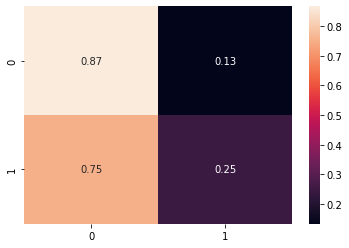

In [96]:
# Predicción con los datos de train
y_predict_train = clf.predict(X_train)

# Preicción con los datos de test
y_predict_test = clf.predict(X_test)

# Impresión de los predict
print(classification_report(y_test, y_predict_test))
print(classification_report(y_train, y_predict_train))

# Mapa de calor para mostrar la eficencia del modelo
sns.heatmap(confusion_matrix(y_test, y_predict_test, normalize='true'),annot=True)

El etiquetado de datos no suele ser trivial dado a que depende de la naturaleza de los datos. Posiblemente, el precio de un activo suba un poco pero luego continue su declive ¿Cuánto tiene que subir/bajar un precio para ser considerado "suba"/"baja"?. ¿Tiene sentido tomar "periodos de suba/baja" más grandes para predecir si el comportamiento del activo en el futuro?. ¿Se podría utilizar un enfoque más estadístico para elegir el etiquetado?.

Aplicar GridSearch sobre los parámetros y luego para la mejor configuración encontrada, evaluar sobre el conjunto de entrenamiento y sobre el conjunto de evaluación, reportando:

- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [97]:
# Selección de parámetros
param_grid = {
    'criterion': ['entropy','gini'],
    'max_depth': [None,2,5,8,10,20],
    'min_samples_split' : [2,3,4,8,10,12]
}

              precision    recall  f1-score   support

          -1       0.32      0.60      0.42        30
           1       0.56      0.28      0.38        53

    accuracy                           0.40        83
   macro avg       0.44      0.44      0.40        83
weighted avg       0.47      0.40      0.39        83

              precision    recall  f1-score   support

          -1       1.00      0.13      0.23        70
           1       0.62      1.00      0.76        98

    accuracy                           0.64       168
   macro avg       0.81      0.56      0.50       168
weighted avg       0.78      0.64      0.54       168



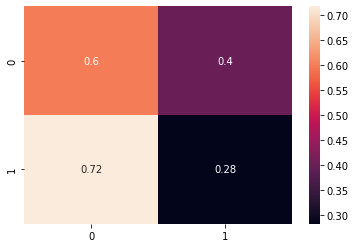

In [98]:
# Selección del mejor modelo
best_model = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5)
best_model.fit(X_train, y_train)

# Impresión de los valores de prección para train y para test con el mejor modelo
y_predict_test = best_model.predict(X_test)
y_predict_train = best_model.predict(X_train)

# Impresión del clasification report para los datos del mejor modelo
print(classification_report(y_test, y_predict_test))
print(classification_report(y_train, y_predict_train))

# Impresión de la matriz de confusión para comprender la eficacia del modelo
sns.heatmap(confusion_matrix(y_test, y_predict_test, normalize='true'),annot=True)